In [60]:
import pandas as pd
pd.set_option("display.max_columns",250)
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import yaml as yaml
# import openpyxl
import random
import geopandas as gpd

sns.set()
# import openmatrix as omx
# import geopandas
# import pyproj
# import re
# import xlrd
from IPython.display import display, HTML

# Original code from 2021 Leah Flake, RSG
# Updated 9/2023 Andrew Rohne, RSG

# INSTRUCTIONS:
# Setup everything in the fields box (should be next):
#  - Survey file is about the specific file (name, type, sheet [if applicable])
#  - Survey fields are specifics to the survey fields
#  - TAZ Shapefile is the TAZ shapefile

# This script will drop some files for validation here...
VALIDATION_DATA_FOLDER = r'E:\Met_Council\metc-asim-model\source\validation\validation_data'




In [61]:
# Fields - set these up to map fields from the survey

# Survey file - set either survey_is_excel or survey_is_csv and survey_file_name (and survey_excel_table if excel, otherwise not used)
survey_is_excel = True
survey_is_csv = False
survey_file_name = 'Met Council OD 2022.xlsx'
survey_excel_table = 'data'

# Survey fields
survey_id = 'ID'
origin_latitude = 'ORIGIN_ADDRESSLAT'
origin_longitude = 'ORIGIN_ADDRESSLONG'
destination_latitude = 'DESTIN_ADDRESSLAT'
destination_longitude = 'DESTIN_ADDRESSLONG'

# Fields used - all of these MUST be filled in!
survey_route_dir_code = 'ROUTE_DIRECTIONCode'
survey_route_dir = 'ROUTE_DIRECTION'
survey_agency = 'Agency'
survey_orig_place_type_code = 'ORIGIN_PLACE_TYPECode'
survey_orig_place_type = 'ORIGIN_PLACE_TYPE'
survey_access_mode_code = 'ORIGIN_TRANSPORTCode'
survey_access_mode = 'ORIGIN_TRANSPORT'
survey_egress_mode_code = 'DESTIN_TRANSPORTCode'
survey_egress_mode = 'DESTIN_TRANSPORT'
survey_dest_place_type_code = 'DESTIN_PLACE_TYPECode'
survey_dest_place_type = 'DESTIN_PLACE_TYPE'
survey_time_on_code = 'TIME_ONCode'
survey_num_employed_in_hh_code = 'EMPLOYED_IN_HHCode'
survey_num_employed_in_hh = 'EMPLOYED_IN_HH'
survey_num_vehicle_in_hh_code = 'COUNT_VH_HHCode'
survey_num_vehicle_in_hh = 'COUNT_VH_HH'
survey_num_persons_in_hh_code = 'HH_SIZECode'
survey_num_persons_in_hh = 'HH_SIZE'
survey_employment_status = 'EMPLOYMENT_STATUSCode'
survey_student_status = 'STUDENT_STATUSCode'
survey_is_licensed = 'DO_YOU_DRIVECode'
survey_age = 'YOUR_AGE'
survey_income_code = 'INCOMECode'
survey_linked_trip_weight = 'Final_Linked_weight_fctr'
survey_unlinked_trip_weight = 'Final_unlinked_weight_fctr'
survey_did_you_go_to_work_code = 'DID_U_GO2WORKCode'
survey_will_you_go_to_work_code = 'WILL_GO2WORKCode'
survey_did_you_go_to_school_code = 'DID_U_GO2SCHOOLCode'
survey_will_you_go_to_school_code = 'WILL_GO2SCHOOLCode'

survey_code_go_to_work_school_yes = 1


# These fields are set to 'No' in a later step - they should be setup if asked
# survey_purpose_no_other_trip
# survey_purpose_buy_meal_beverage
# survey_purpose_work
# survey_purpose_visit    #'TRIP_PURPOSE_VISIT_FRIEND/RELATIVE_OR_ATTEND_RELIGIOUS/SOC_EVENT'
# survey_purpose_school
# survey_purpose_shopping
# survey_purpose_other_errands
# survey_purpose_other

# applied to place types, all inputs must be represented
survey_purpose_codes = {
    1: 'Work',
    2: 'Home',
    5: 'University',
    6: 'K-12 school',
    7: 'Maintenance',
    8: 'Maintenance',
    9: 'Discretionary',
    11: 'Discretionary',
    12: 'Maintenance',
    13: 'Discretionary',
    14: 'Discretionary',
    98: 'Maintenance',
    99: 'Maintenance'
}

knr_access_modes = [4, 7]
pnr_access_modes = [5, 6]

# TAZ Shapefile and TAZ field - shapefile only, and must have the projection set
taz_shapefile = r'E:\Met_Council\metc-asim-model\Input_2022\Visualizer\SHP\TAZ2010.shp'
taz_shp_taz_id = 'TAZ'



In [62]:
def add_percentage_to_crosstab(ct):
    total_counts = ct['All'][:-1].sum()
    ct['Percent'] = ct.apply(lambda row: round(100 * row['All'] / total_counts, 2), axis=1)
    ct.loc['Percent'] = ct.apply(lambda col: round(100 * col['All'] / total_counts, 2), axis=0)
    ct.loc['Percent', 'Percent'] = pd.NA
    return ct

In [63]:
def make_percentage_bar_plot(variable, title, xlabel, xlabel_rotation):
    grouped_df = obs_df.groupby(variable)["unlinked_weight_scaled"].agg(sum)
    total_weight = grouped_df.sum()
    grouped_df["percent"] = grouped_df/total_weight*100
    plt.figure(figsize=(10,7))
    grouped_df["percent"].plot.bar()
    plt.xlabel(xlabel, fontsize=16)
    plt.xticks(rotation=xlabel_rotation)
    plt.ylabel("Weighted Percent", fontsize=16)
    plt.title(title, fontsize=16)
    plt.show()
    
def make_percentage_bar_plot_cta(variable, title, xlabel, xlabel_rotation):
    grouped_df = obs_df.groupby(variable)["unlinked_weight_scaled"].agg(sum)
    total_weight = grouped_df.sum()
    grouped_df["percent"] = grouped_df/total_weight*100
    plt.figure(figsize=(10,7))
    grouped_df["percent"].plot.bar()
    plt.xlabel(xlabel, fontsize=16)
    plt.xticks(rotation=xlabel_rotation)
    plt.ylabel("Weighted Percent", fontsize=16)
    plt.title(title, fontsize=16)
    plt.show()
    
def make_percentage_bar_plot_metra(variable, title, xlabel, xlabel_rotation):
    grouped_df = metra_df.groupby(variable)["unlinked_weight_scaled"].agg(sum)
    total_weight = grouped_df.sum()
    grouped_df["percent"] = grouped_df/total_weight*100
    plt.figure(figsize=(10,7))
    grouped_df["percent"].plot.bar()
    plt.xlabel(xlabel, fontsize=16)
    plt.xticks(rotation=xlabel_rotation)
    plt.ylabel("Weighted Percent", fontsize=16)
    plt.title(title, fontsize=16)
    plt.show()

In [64]:

with open(r'E:\Met_Council\metc-asim-model\source\survey_data_processing\metc_inputs_phase2.yml') as file:
    settings = yaml.load(file, Loader = yaml.SafeLoader)

obs_path  = os.path.join(settings['obs_dir'], survey_file_name)

output_path = r"output"


# TAZ Identification

In [65]:
if survey_is_excel:
    obs_df = pd.read_excel(obs_path, survey_excel_table)
elif survey_is_csv:
    obs_df = pd.read_csv(obs_path)
else:
    assert False, "Survey must be either Excel or CSV and survey_is_excel or survey_is_csv must be set appropriately"

taz = gpd.read_file(taz_shapefile).to_crs("EPSG:4326")
origins_points = gpd.GeoDataFrame(obs_df[[survey_id, origin_latitude, origin_longitude]], geometry=gpd.points_from_xy(obs_df[origin_longitude], obs_df[origin_latitude]), crs = "EPSG:4326")
destinations_points = gpd.GeoDataFrame(obs_df[[survey_id, destination_latitude, destination_longitude]], geometry=gpd.points_from_xy(obs_df[destination_longitude], obs_df[destination_latitude]), crs = "EPSG:4326")

origins = gpd.sjoin(origins_points, taz).rename(columns = {taz_shp_taz_id: 'O_TAZ'})
destinations = gpd.sjoin(destinations_points, taz).rename(columns = {taz_shp_taz_id: 'D_TAZ'})

obs_df = obs_df.merge(origins[[survey_id, 'O_TAZ']], how = 'left', on = survey_id).merge(destinations[[survey_id, 'D_TAZ']], how = 'left', on = survey_id)

# QC
print(f'Origins: {obs_df.O_TAZ.nunique()} unique TAZs, {round((100 * obs_df.O_TAZ.nunique() / taz.shape[0]), 2)}% of TAZs have an origin')
print(f'Most common origin is {obs_df.O_TAZ.mode()[0]} with {obs_df[obs_df.O_TAZ == obs_df.O_TAZ.mode()[0]].shape[0]} origins ({round(100 * obs_df[obs_df.O_TAZ == obs_df.O_TAZ.mode()[0]].shape[0] / obs_df.shape[0], 2)}%)')
print('\n')
print(f'Destinations: {obs_df.D_TAZ.nunique()} unique TAZs, {round((100 * obs_df.D_TAZ.nunique() / taz.shape[0]), 2)}% of TAZs have an destination')
print(f'Most common destination is {obs_df.D_TAZ.mode()[0]} with {obs_df[obs_df.D_TAZ == obs_df.D_TAZ.mode()[0]].shape[0]} origins ({round(100 * obs_df[obs_df.D_TAZ == obs_df.D_TAZ.mode()[0]].shape[0] / obs_df.shape[0], 2)}%)')


Origins: 1443 unique TAZs, 47.62% of TAZs have an origin
Most common origin is 1530.0 with 650 origins (3.05%)


Destinations: 1421 unique TAZs, 46.9% of TAZs have an destination
Most common destination is 1530.0 with 718 origins (3.37%)


In [66]:
obs_df.shape

(21278, 248)

In [67]:
print("Total entries in the on board survey:", len(obs_df))
print("Weighted total of entries in the on board survey (unlinked):", obs_df['Final_unlinked_weight_fctr'].sum())
print("Weighted total of trips in the on board survey (linked):", obs_df['Final_Linked_weight_fctr'].sum())


Total entries in the on board survey: 21278
Weighted total of entries in the on board survey (unlinked): 147929.12313604102
Weighted total of trips in the on board survey (linked): 124008.33261468509


# Transit Onboard Survey Data Coding

## Recode relevant variables to match between each dataset

In [68]:

obs_df_orig = obs_df.copy()

obs_df.rename(columns = {
    survey_route_dir_code: 'ROUTE_SURVEYED_CODE',
    survey_route_dir: 'ROUTE_SURVEYED',
    survey_agency: 'ROUTE_PROVIDER',
    survey_orig_place_type_code: 'ORIGIN_PLACE_TYPE_CODE',
    survey_orig_place_type: 'ORIGIN_PLACE_TYPE',
    survey_access_mode_code: 'ACCESS_MODE_CODE',
    survey_access_mode: 'ACCESS_MODE',
    survey_egress_mode_code: 'EGRESS_MODE_CODE',
    survey_egress_mode: 'EGRESS_MODE',
    survey_dest_place_type_code: 'DESTIN_PLACE_TYPE_CODE',
    survey_dest_place_type: 'DESTIN_PLACE_TYPE',
    survey_time_on_code: 'TIME_ON_CODE',
    survey_num_employed_in_hh_code: 'COUNT_EMPLOYED_HH_CODE',
    survey_num_employed_in_hh: 'COUNT_EMPLOYED_HH',
    survey_num_vehicle_in_hh_code: 'COUNT_VH_HH_CODE',
    survey_num_vehicle_in_hh: 'COUNT_VH_HH',
    survey_num_persons_in_hh_code: 'COUNT_MEMBER_HH_CODE',
    survey_num_persons_in_hh: 'COUNT_MEMBER_HH',
    survey_employment_status: 'STATUS_EMPLOYMENT',
    survey_student_status: 'STUDENT_STATUS',
    survey_is_licensed: 'HAS_DRIVE_LICENSE',
    survey_age: 'AGE',
    survey_income_code: 'INCOME_CODE',
    survey_did_you_go_to_work_code:  'DID_U_GO2WORK[Code]',
    survey_will_you_go_to_work_code: 'WILL_GO2WORK[Code]',
    survey_did_you_go_to_school_code: 'DID_U_GO2SCHOOL[Code]',
    survey_will_you_go_to_school_code: 'WILL_GO2SCHOOL[Code]',
    survey_unlinked_trip_weight: 'Unlinked_Weight-AE',
    survey_linked_trip_weight: 'Linked_Weight-AE'}, inplace = True)

obs_df['TRIP_PURPOSE_GO_TO_WORK'] = 'No'
obs_df.loc[(obs_df['DID_U_GO2WORK[Code]'] == survey_code_go_to_work_school_yes) | (obs_df['WILL_GO2WORK[Code]'] == survey_code_go_to_work_school_yes), 'TRIP_PURPOSE_GO_TO_WORK'] = 'Yes'

obs_df['TRIP_PURPOSE_GO_TO_SCHOOL'] = 'No'
obs_df.loc[(obs_df['DID_U_GO2SCHOOL[Code]'] == survey_code_go_to_work_school_yes) | (obs_df['WILL_GO2SCHOOL[Code]'] == survey_code_go_to_work_school_yes), 'TRIP_PURPOSE_GO_TO_SCHOOL'] = 'Yes'


# These are placeholders - the questions were apparently not asked in the 2023 OBS
obs_df['TRIP_PURPOSE_NO_OTHER_TRIP'] = 'No'
obs_df['TRIP_PURPOSE_BUY_A_MEAL_/_BEVERAGE'] = 'No'
obs_df['TRIP_PURPOSE_GO_TO_WORK'] = 'No'
obs_df['TRIP_PURPOSE_VISIT_FRIEND/RELATIVE_OR_ATTEND_RELIGIOUS/SOC_EVENT'] = 'No'
obs_df['TRIP_PURPOSE_GO_TO_SCHOOL'] = 'No'
obs_df['TRIP_PURPOSE_GO_SHOPPING'] = 'No'
obs_df['TRIP_PURPOSE_OTHER_ERRANDS'] = 'No'
obs_df['TRIP_PURPOSE_OTHER'] = 'No'


In [69]:

# Route Naming

def zero_pad(a, l):
    y = ""
    for x in range(len(a), l):
        y += '0'
    y += a
    return(y)

obs_df['ROUTE'] = obs_df['ROUTE_SURVEYED_CODE'].apply(lambda x: zero_pad(x[6:x.rfind("_")], 3))


In [70]:
obs_df = obs_df[['ID', 'ROUTE_SURVEYED_CODE', 'ROUTE_SURVEYED', 'ROUTE', 
  'ROUTE_PROVIDER','ORIGIN_PLACE_TYPE_CODE','ORIGIN_PLACE_TYPE', 
                      'ACCESS_MODE_CODE','ACCESS_MODE', 'EGRESS_MODE_CODE', 'EGRESS_MODE',
                     'DESTIN_PLACE_TYPE_CODE', 'DESTIN_PLACE_TYPE', 
                      'TIME_ON', 'TIME_PERIOD', 'TIME_ON_CODE',
                      'TRIP_PURPOSE_NO_OTHER_TRIP',
                     'TRIP_PURPOSE_BUY_A_MEAL_/_BEVERAGE',
                     'TRIP_PURPOSE_GO_TO_WORK',
                     'TRIP_PURPOSE_VISIT_FRIEND/RELATIVE_OR_ATTEND_RELIGIOUS/SOC_EVENT',
                     'TRIP_PURPOSE_GO_TO_SCHOOL',
                     'TRIP_PURPOSE_GO_SHOPPING',
                     'TRIP_PURPOSE_OTHER_ERRANDS',
                     'TRIP_PURPOSE_OTHER',
                      'COUNT_EMPLOYED_HH_CODE', 'COUNT_EMPLOYED_HH',
                      'COUNT_VH_HH_CODE', 'COUNT_VH_HH',
                      'COUNT_MEMBER_HH_CODE', 'COUNT_MEMBER_HH', 'STATUS_EMPLOYMENT', 'STUDENT_STATUS',
                    'HAS_DRIVE_LICENSE', 'AGE', 'INCOME_CODE', 'INCOME', 
                      'O_TAZ', 'D_TAZ', 'Unlinked_Weight-AE', 'Linked_Weight-AE']].copy()





### Boardings by route


Questions:

In [71]:
obs_route_df = obs_df.groupby(['ROUTE_PROVIDER'])['Unlinked_Weight-AE'].agg(sum).sort_index(level='ROUTE_PROVIDER').to_frame()
obs_route_df['Percent'] = obs_route_df['Unlinked_Weight-AE'] / obs_route_df['Unlinked_Weight-AE'].sum() * 100

# print(route_dict.head())
display(HTML(obs_route_df.to_html()))

,Unlinked_Weight-AE,Percent
ROUTE_PROVIDER,,
MET,144451.153,97.649
MNV,3477.970,2.351


In [72]:
obs_df['ORIG_PURPOSE'] = obs_df['ORIGIN_PLACE_TYPE_CODE'].map(survey_purpose_codes)
obs_df['DEST_PURPOSE'] = obs_df['DESTIN_PLACE_TYPE_CODE'].map(survey_purpose_codes)

In [73]:
print(obs_df['ORIG_PURPOSE'].value_counts())
print(obs_df['DEST_PURPOSE'].value_counts())


Home             11170
Work              3716
Maintenance       3396
Discretionary     1761
University        1088
K-12 school        147
Name: ORIG_PURPOSE, dtype: int64
Home             7421
Work             5494
Maintenance      4210
Discretionary    2754
University       1160
K-12 school       239
Name: DEST_PURPOSE, dtype: int64


### Access mode

* 1 - PNR (driving, carshare)
* 2 - KNR (dropped off, taxi/TNC)
* 3 - Walk (includes bike, scooter, skateboard)

Questions:
* Should taxi be TNC?


In [74]:
# Code access/egress before imputation ... updated for 2023 OBS

def code_access_mode(value):
    if (value in  knr_access_modes):
        return 'PNR'
    elif (value in pnr_access_modes):
        return 'PNR'
    return 'Walk'

obs_df['access_mode'] = obs_df['ACCESS_MODE_CODE'].apply(lambda value: code_access_mode(value))
obs_df['egress_mode'] = obs_df['EGRESS_MODE_CODE'].apply(lambda value: code_access_mode(value))


In [75]:
obs_df.groupby('ACCESS_MODE').agg(linked_trips = ('Linked_Weight-AE', 'sum'), unlinked_trips = ('Unlinked_Weight-AE', 'sum'))

,linked_trips,unlinked_trips
ACCESS_MODE,,
Drove alone and parked,3367.558,3591.372
Drove or rode with others and parked,338.315,386.312
My bike / e-bike / scooter / skateboard,1329.780,1531.404
Other,16.862,34.624
"Shared bike / e-bike / scooter (e.g. Nice Ride, Bird, Lime)",84.081,97.542
"Uber, Lyft, Taxi (smartphone ride hailing)",192.546,227.503
"Walk, jog, or roll using a mobility device (e.g. wheelchair)",117219.031,140348.450
Was dropped off by someone,1460.159,1711.917


In [76]:
obs_df.groupby('EGRESS_MODE').agg(linked_trips = ('Linked_Weight-AE', 'sum'), unlinked_trips = ('Unlinked_Weight-AE', 'sum'))

,linked_trips,unlinked_trips
EGRESS_MODE,,
Be picked up by someone,823.924,944.089
Get in a parked vehicle & drive alone,3578.457,3624.795
Get in a parked vehicle & drive/ride with others,396.294,420.897
My bike / e-bike / scooter / skateboard,1315.844,1485.766
Other,9.721,23.784
"Shared bike / e-bike / scooter (e.g. Nice Ride, Bird, Lime)",111.617,115.852
"Uber, Lyft, Taxi (smartphone ride hailing)",132.679,173.950
"Walk, jog, or roll using a mobility device (e.g. wheelchair)",117639.795,141139.992


In [77]:
obs_df.groupby(['ACCESS_MODE', 'EGRESS_MODE']).agg(linked_trips = ('Linked_Weight-AE', 'sum')).reset_index().pivot(index = 'ACCESS_MODE', columns = 'EGRESS_MODE', values = 'linked_trips')

EGRESS_MODE,Be picked up by someone,Get in a parked vehicle & drive alone,Get in a parked vehicle & drive/ride with others,My bike / e-bike / scooter / skateboard,Other,"Shared bike / e-bike / scooter (e.g. Nice Ride, Bird, Lime)","Uber, Lyft, Taxi (smartphone ride hailing)","Walk, jog, or roll using a mobility device (e.g. wheelchair)"
ACCESS_MODE,,,,,,,,
Drove alone and parked,NaN,87.287,15.513,21.025,NaN,NaN,NaN,3243.733
Drove or rode with others and parked,NaN,14.924,6.018,19.915,NaN,NaN,NaN,297.458
My bike / e-bike / scooter / skateboard,NaN,NaN,NaN,762.604,NaN,4.471,NaN,562.705
Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.862
"Shared bike / e-bike / scooter (e.g. Nice Ride, Bird, Lime)",NaN,NaN,NaN,2.772,NaN,18.334,NaN,62.975
"Uber, Lyft, Taxi (smartphone ride hailing)",3.732,6.694,NaN,NaN,NaN,NaN,11.891,170.229
"Walk, jog, or roll using a mobility device (e.g. wheelchair)",787.351,3464.405,372.167,509.528,9.721,88.812,120.788,111866.259
Was dropped off by someone,32.841,5.147,2.596,NaN,NaN,NaN,NaN,1419.575


In [78]:
orig_dest_ct = pd.crosstab(obs_df['access_mode'], obs_df['egress_mode'], values=obs_df['Unlinked_Weight-AE'], aggfunc=sum, margins=True)
orig_dest_ct = add_percentage_to_crosstab(orig_dest_ct)
orig_dest_ct.fillna(0, inplace=True)
orig_dest_ct.applymap(lambda x: round(x,2))


egress_mode,PNR,Walk,All,Percent
access_mode,,,,
PNR,199.530,5717.570,5917.100,4.000
Walk,4964.200,137047.820,142012.020,96.000
All,5163.730,142765.390,147929.120,100.000
Percent,3.490,96.510,100.000,0.000


### Auto Sufficiency
* 0 for households with no autos
* 1 for households that have 0 < autos < number of workers
* 2 for households that have 0 < autos >= number of workers

Questions:
* Auto suff for Metra was imputed in R based on CMAP data
  * Mainly resulted in auto suff "vehicles greater than or equal to workers"
  * Does that make sense for commuter rail?
* Some missing hh employed or hh veh in CTA

In [79]:
obs_df['auto_suff'] = -1



In [80]:

obs_df.loc[obs_df.COUNT_VH_HH_CODE != '10P', 'hh_veh'] = obs_df.COUNT_VH_HH_CODE
obs_df.loc[obs_df.COUNT_VH_HH_CODE == '10P','hh_veh'] = 10
obs_df['hh_veh'] = pd.to_numeric(obs_df['hh_veh'])

obs_df.loc[pd.isna(obs_df.COUNT_EMPLOYED_HH_CODE), 'hh_employed'] = 0

obs_df['hh_employed'] = pd.to_numeric(obs_df['COUNT_EMPLOYED_HH_CODE'])
obs_df.loc[obs_df.hh_veh < obs_df.hh_employed, 'auto_suff'] = 1
obs_df.loc[obs_df.hh_veh >= obs_df.hh_employed, 'auto_suff'] = 2
obs_df.loc[obs_df.hh_veh == 0, 'auto_suff'] = 0



In [81]:
print(obs_df['auto_suff'].value_counts(normalize = True))
print(obs_df[obs_df['auto_suff'] >=0]['auto_suff'].value_counts(normalize = True))
print(obs_df['hh_veh'].value_counts())
print(obs_df['hh_employed'].value_counts())



0   0.528
1   0.241
2   0.231
Name: auto_suff, dtype: float64
0   0.528
1   0.241
2   0.231
Name: auto_suff, dtype: float64
0     11236
1      5759
2      3073
3       803
4       274
5        68
6        26
10       24
7        10
9         3
8         2
Name: hh_veh, dtype: int64
1     7967
2     6459
0     3509
3     2159
4      756
5      238
6       75
10      56
7       36
8       18
9        5
Name: hh_employed, dtype: int64


In [82]:
# impute autosuff based on overall distribution

# 0    0.342
# 1    0.272
# 2    0.386
random.seed(413)

m = obs_df[obs_df['auto_suff']<0].shape[0]

s = np.random.choice([0, 1, 2],
                     p=[ 0.342, 0.272,0.386], 
                     size = m)
print(s)

obs_df.loc[obs_df['auto_suff'] < 0, 'auto_suff'] = s

[]


In [83]:
# # Scale to boardings in oct 2018
# pd.set_option('display.max_rows', 130)

# metcouncil_boardings = ...

# Assume updated weights will have right boarding sum?
# Scale missing purposes


weight_sum = obs_df['Unlinked_Weight-AE'].sum()
linked_weight_sum =  obs_df['Linked_Weight-AE'].sum()
print(weight_sum)
print(linked_weight_sum)
obs_df = obs_df[~obs_df['ORIGIN_PLACE_TYPE_CODE'].isnull()]

weight_sum_2 =  obs_df['Unlinked_Weight-AE'].sum()
linked_weight_sum_2 =  obs_df['Linked_Weight-AE'].sum()

obs_df['unlinked_weight_scaled'] = obs_df['Unlinked_Weight-AE'] * (weight_sum/weight_sum_2)
obs_df['linked_weight_scaled'] = obs_df['Linked_Weight-AE'] * (linked_weight_sum/linked_weight_sum_2)
print('scaled weights')
print(obs_df.unlinked_weight_scaled.sum())
print(obs_df.linked_weight_scaled.sum())


147929.12313604102
124008.33261468509
scaled weights
147929.12313604102
124008.33261468509


In [84]:
obs_df.groupby('auto_suff').agg(linked_trips = ('linked_weight_scaled', sum), unlinked_trips = ('unlinked_weight_scaled', sum))

,linked_trips,unlinked_trips
auto_suff,,
0,64652.452,78737.710
1,28872.781,34422.103
2,30483.100,34769.310


#### Impute tour purposes for non-work tours:

Impute work tours/sub-tours and joint tour purposes where applicable using time of day.

* Impute work tours from maintenance/discretionary tours 
* Impute work sub-tours where neither end is home
* Impute joint tours from maintenance/discretionary tours that remain

Metra is only first half of the day, so have to do it on regular metra dataset before combining



In [85]:
obs_df.TIME_ON.value_counts()
# metra_df.Time.value_counts()

7:00 am - 8:00 am      1887
8:00 am - 9:00 am      1783
9:01 am - 10:00 am     1588
4:00 pm - 5:00 pm      1578
3:01 pm - 4:00 pm      1551
10:00 am - 11:00 am    1517
11:00 am - 12:00 pm    1441
2:00 pm - 3:00 pm      1428
1:00 pm - 2:00 pm      1382
5:00 pm - 6:00 pm      1260
12:00 pm - 1:00 pm     1205
7:00 pm - 8:00 pm      1161
6:00 am - 7:00 am      1139
8:00 pm - 9:00 pm       793
6:31 pm - 7:00 pm       706
6:00 pm - 6:30 pm       625
After 9:00 pm           136
Before 6:00 am           98
Name: TIME_ON, dtype: int64

### Tour Purpose

* Work (home-based-work or work-based tour)
* School
* Other - use a hierarchy


In [86]:
purpose_ct = pd.crosstab(
    obs_df['ORIG_PURPOSE'],
    obs_df['DEST_PURPOSE'],
    values=obs_df['unlinked_weight_scaled'],
    aggfunc=sum,
    normalize='all',
    margins=True)*100
# purpose_ct = add_percentage_to_crosstab(purpose_ct)
# purpose_ct.fillna(0, inplace=True)
purpose_ct.applymap(lambda x: round(x,2))

DEST_PURPOSE,Discretionary,Home,K-12 school,Maintenance,University,Work,All
ORIG_PURPOSE,,,,,,,
Discretionary,1.370,4.770,0.020,1.120,0.380,0.490,8.150
Home,8.190,0.000,0.870,12.670,6.560,20.340,48.630
K-12 school,0.040,0.660,0.000,0.040,0.000,0.070,0.810
Maintenance,1.900,10.540,0.000,2.460,0.110,0.420,15.430
University,0.460,6.530,0.020,0.320,1.210,0.150,8.690
Work,0.790,15.900,0.010,1.190,0.160,0.270,18.300
All,12.740,38.390,0.910,17.800,8.420,21.740,100.000


In [87]:
def determine_tour_purpose(orig_purpose, dest_purpose):
    if (orig_purpose == 'Work') & (dest_purpose == 'Work'):
        return 'Work sub-tour'
    if (orig_purpose == 'Work') | (dest_purpose == 'Work'):
        return 'Work'
    if (orig_purpose == 'Other work') | (dest_purpose == 'Other work'):
        return 'Maintenance'
    if (orig_purpose == 'University') | (dest_purpose == 'University'):
        return 'University'
    if (orig_purpose == 'K-12 school') | (dest_purpose == 'K-12 school'):
        return 'School'
    if (orig_purpose == 'Maintenance') | (dest_purpose == 'Maintenance'):
        return 'Maintenance'
    if (orig_purpose == 'Discretionary') | (dest_purpose == 'Discretionary'):
        return 'Discretionary'
    if (orig_purpose == 'Home') & (dest_purpose != 'Home'):
        return dest_purpose
    if (orig_purpose != 'Home') & (dest_purpose == 'Home'):
        return orig_purpose
    if (orig_purpose == 'Home') & (dest_purpose == 'Home'):
        return 'Discretionary'
    if orig_purpose == dest_purpose:
        return orig_purpose
    return dest_purpose

obs_df['TOUR_PURPOSE'] = obs_df.apply(lambda row: determine_tour_purpose(row['ORIG_PURPOSE'], row['DEST_PURPOSE']), axis=1)

# home-home as other discrectionary
# Social/visiting vs. other discretionary
# Recreation & sporting in "other discretionary"


In [88]:
# use trip weights instead
obs_df['TOUR_PURPOSE'].value_counts(dropna=False)
obs_df.groupby(['TOUR_PURPOSE'])['linked_weight_scaled'].agg(sum).sort_index(level='TOUR_PURPOSE')


TOUR_PURPOSE
Discretionary   17378.050
Maintenance     35616.736
School           2039.257
University      21664.987
Work            46958.448
Work sub-tour     350.854
Name: linked_weight_scaled, dtype: float64

In [89]:
obs_df.groupby(['TOUR_PURPOSE'])['unlinked_weight_scaled'].agg(sum).sort_index(level='TOUR_PURPOSE')

TOUR_PURPOSE
Discretionary   21198.340
Maintenance     42453.910
School           2395.522
University      23048.935
Work            58438.949
Work sub-tour     393.467
Name: unlinked_weight_scaled, dtype: float64

In [90]:
# access/egress individually coded earlier
pd.set_option('display.float_format', lambda x: '%.3f' % x)
# code access based on both access/egress
def determine_tour_mode(row):
    if (row['access_mode'] == 'PNR') | (row['egress_mode'] == 'PNR'):
        return 'PNR'
    if (row['access_mode'] == 'TNR') | (row['egress_mode'] == 'TNR'):
        return 'PNR'
    if (row['access_mode'] == 'KNR') | (row['egress_mode'] == 'KNR'):
        return 'PNR'
    return 'Walk'

obs_df['TOUR_MODE'] = obs_df.apply(lambda row: determine_tour_mode(row), axis=1)
access_df = obs_df.groupby(['TOUR_MODE'])['unlinked_weight_scaled'].agg(sum).sort_index(level='TOUR_MODE').to_frame()
access_df['Percent'] = access_df['unlinked_weight_scaled'] / access_df['unlinked_weight_scaled'].sum() * 100



print(access_df)

obs_df.groupby(['TOUR_MODE'])['unlinked_weight_scaled'].agg(sum).sort_index(level='TOUR_MODE')

           unlinked_weight_scaled  Percent
TOUR_MODE                                 
PNR                     10881.302    7.356
Walk                   137047.821   92.644


TOUR_MODE
PNR     10881.302
Walk   137047.821
Name: unlinked_weight_scaled, dtype: float64

In [91]:
obs_df['TIME_ON_CODE'].value_counts().sort_index()

AM1       98
AM2     1139
AM3     1887
AM4     1783
MID1    1588
MID2    1517
MID3    1441
MID4    1205
MID5    1382
MID6    1428
PM1     1551
PM2     1578
PM3     1260
PM4      625
PM5      706
PM6     1161
PM7      793
PM8      136
Name: TIME_ON_CODE, dtype: int64

In [92]:
# derive TOD/use CMAP utilities for now



obs_df.loc[obs_df['TIME_ON_CODE'].isin(['MID1', 'MID2', 'MID3', 'MID4', 'MID5', 'MID6']) , 'TOD'] = '9:01 am - 3:00 pm'
obs_df.loc[obs_df['TIME_ON_CODE'].isin(['MID2', 'MID3', 'MID4', 'MID5']), 'TOD'] = '10:01 am - 2:00 pm'


In [93]:
# Impute work tour purpose
# Limit to workers, tour purpose is maintenance/discretionary
# limit to weekdays? need to ask -- Day_Type_2 == 1

obs_df['TOUR_PURPOSE_INIT'] = obs_df['TOUR_PURPOSE']
obs_df['imputed_tour_purpose'] = ''

# calculate utility work tour based on model coefficients
obs_df['uWTP'] = -0.480

# original tour purpose
obs_df.loc[(obs_df['TOUR_PURPOSE_INIT'] == 'Discretionary'), 'uWTP'] = obs_df[obs_df['TOUR_PURPOSE_INIT'] == 'Discretionary']['uWTP'] + (-0.961)


# surveyed hour
obs_df.loc[(obs_df['TOD'] == '9:01 am - 3:00 pm'), 'uWTP'] = obs_df[(obs_df['TOD'] == '9:01 am - 3:00 pm')]['uWTP'] + (-1.21)
obs_df.loc[(obs_df['TIME_ON_CODE'] == 12), 'uWTP'] = obs_df[(obs_df['TIME_ON_CODE'] == 12)]['uWTP'] + (-0.19 ) # 4pm
obs_df.loc[(obs_df['TIME_ON_CODE'] == 13), 'uWTP'] = obs_df[(obs_df['TIME_ON_CODE'] == 13)]['uWTP'] + (-0.365) # 5pm
obs_df.loc[(obs_df['TIME_ON_CODE'] == 14) | (obs_df['TIME_ON_CODE'] == 15), 'uWTP'] = obs_df[(obs_df['TIME_ON_CODE'] == 14) | (obs_df['TIME_ON_CODE'] == 15)]['uWTP'] + (-0.932) # 6pm
obs_df.loc[(obs_df['TIME_ON_CODE'] == 16), 'uWTP'] = obs_df[(obs_df['TIME_ON_CODE'] == 16)]['uWTP'] + (-1.25) # 7pm
obs_df.loc[(obs_df['TIME_ON_CODE'] == 17), 'uWTP'] = obs_df[(obs_df['TIME_ON_CODE'] == 17)]['uWTP'] + (-1.46) # 8pm
obs_df.loc[(obs_df['TIME_ON_CODE'] == 18), 'uWTP'] = obs_df[(obs_df['TIME_ON_CODE'] == 18)]['uWTP'] + (-1.12) # >9pm

# access mode
obs_df.loc[(obs_df['TOUR_MODE'] == 'PNR'), 'uWTP'] = obs_df[(obs_df['TOUR_MODE'] == 'PNR')]['uWTP'] + (1.12) 
obs_df.loc[(obs_df['TOUR_MODE'] == 'KNR'), 'uWTP'] = obs_df[(obs_df['TOUR_MODE'] == 'KNR')]['uWTP'] + (1.78) 

# calculate probability
obs_df['expuWTP'] = np.exp(obs_df['uWTP'])
obs_df['probWTP'] = obs_df['expuWTP']/(1 + obs_df['expuWTP'])

print(obs_df['probWTP'].value_counts(dropna=False))

# Generate random number
np.random.seed(30)
obs_df['randn'] = np.random.uniform(0, 1, obs_df.shape[0])

obs_df.loc[(obs_df['randn'] < obs_df['probWTP']), 'imputed_tour_purpose'] = 'Work'
obs_df.loc[(obs_df['randn'] >= obs_df['probWTP']), 'imputed_tour_purpose'] = 'replace'


print(np.mean(obs_df['probWTP']))
print(obs_df[obs_df['imputed_tour_purpose'] == 'Work'].shape[0]/
      (obs_df[obs_df['imputed_tour_purpose'] == 'Work'].shape[0] + 
       obs_df[obs_df['imputed_tour_purpose'] == 'replace'].shape[0]))

obs_df.loc[(obs_df['hh_employed'] > 0) & 
           (obs_df['imputed_tour_purpose'] == 'Work') & 
           (obs_df['TOUR_PURPOSE_INIT'].isin(['Maintenance', 'Discretionary'])), 'TOUR_PURPOSE'] = obs_df[(obs_df['hh_employed'] > 0) & 
               (obs_df['imputed_tour_purpose'] == 'Work') & 
               (obs_df['TOUR_PURPOSE_INIT'].isin(['Maintenance', 'Discretionary']))]['imputed_tour_purpose']

obs_df.groupby(['TOUR_PURPOSE'])['linked_weight_scaled'].agg(sum).sort_index(level='TOUR_PURPOSE')



0.382    14168
0.191     2647
0.156     2550
0.655     1361
0.066      348
0.361      108
0.420       86
0.178       10
Name: probWTP, dtype: int64
0.3435754613997259
0.3410564902716421


TOUR_PURPOSE
Discretionary   15073.062
Maintenance     27182.660
School           2039.257
University      21664.987
Work            57697.512
Work sub-tour     350.854
Name: linked_weight_scaled, dtype: float64

In [94]:
# Derive observed/surveyed hour (as a sub for departure hour)


# # pd.to_datetime(obs_df['StartTime']).head()
# obs_df['surveyed_hour'] = pd.to_datetime(obs_df['StartTime']).dt.hour

# obs_df['surveyed_hour'].value_counts(dropna=False).sort_index(level='surveyed_hour')


In [95]:
# Impute work sub-tour purpose
# Limit to origin/destination not home

# calculate utility work subtour based on model coefficients
obs_df['uWST'] = -5.16

obs_df.loc[(obs_df['ORIG_PURPOSE'] == 'Work') | (obs_df['DEST_PURPOSE'] == 'Work'), 'uWST'] = \
    obs_df[(obs_df['ORIG_PURPOSE'] == 'Work') | (obs_df['DEST_PURPOSE'] == 'Work')]['uWST'] + (2.68 )
obs_df.loc[(obs_df['TOD'] == '10:01 am - 2:00 pm'), 'uWST'] = obs_df[(obs_df['TOD'] == '10:01 am - 2:00 pm')]['uWST'] + (1.63)
obs_df.loc[(obs_df['TIME_ON_CODE'] == 8), 'uWST'] = obs_df[(obs_df['TIME_ON_CODE'] == 8)]['uWST'] + (0.458)



# calculate probability
obs_df['expuWST'] = np.exp(obs_df['uWST'])
obs_df['probWST'] = obs_df['expuWST']/(1 + obs_df['expuWST'])

print(obs_df['probWST'].value_counts(dropna=False))

# Generate random number
obs_df['randn'] = np.random.uniform(0, 1, obs_df.shape[0])

obs_df.loc[(obs_df['randn'] < obs_df['probWST']), 'imputed_tour_purpose'] = 'Work sub-tour'
obs_df.loc[(obs_df['randn'] >= obs_df['probWST']), 'imputed_tour_purpose'] = 'replace'


print(np.mean(obs_df['probWST']))
print(obs_df[obs_df['imputed_tour_purpose'] == 'Work sub-tour'].shape[0]/
      (obs_df[obs_df['imputed_tour_purpose'] == 'Work sub-tour'].shape[0] + 
       obs_df[obs_df['imputed_tour_purpose'] == 'replace'].shape[0]))

obs_df.loc[(obs_df['imputed_tour_purpose'] == 'Work sub-tour') & 
           (obs_df['ORIG_PURPOSE'] != 'Home') & 
           (obs_df['DEST_PURPOSE'] != 'Home'), 'TOUR_PURPOSE'] = obs_df[(obs_df['imputed_tour_purpose'] == 'Work sub-tour') & 
           (obs_df['ORIG_PURPOSE'] != 'Home') & 
           (obs_df['DEST_PURPOSE'] != 'Home')]['imputed_tour_purpose']

obs_df.groupby(['TOUR_PURPOSE'])['linked_weight_scaled'].agg(sum).sort_index(level='TOUR_PURPOSE')



0.006    8191
0.077    7542
0.028    3940
0.299    1605
Name: probWST, dtype: int64
0.05744489944673106
0.05968606071999248


TOUR_PURPOSE
Discretionary   15062.539
Maintenance     27074.904
School           2039.257
University      21663.534
Work            57213.067
Work sub-tour     955.031
Name: linked_weight_scaled, dtype: float64

In [96]:

obs_df.COUNT_MEMBER_HH_CODE.value_counts()


1     7101
2     5138
3     3448
4     2965
5     1573
6      529
7      199
10     193
8      100
9       32
Name: COUNT_MEMBER_HH_CODE, dtype: int64

In [97]:
# Impute joint tour
# Limit to hhsize >1 and maintenance/discretionary tour purpose (after prev steps)

# calculate utility fully joint tour based on model coefficients
obs_df['uFJT'] = -2.65

# surveyed hour
obs_df.loc[(obs_df['TOD'] == '9:01 am - 3:00 pm'), 'uFJT'] = obs_df[(obs_df['TOD'] == '9:01 am - 3:00 pm')]['uFJT'] + (0.567)
obs_df.loc[(obs_df['TIME_ON_CODE'] == 'PM2'), 'uWTP'] = obs_df[(obs_df['TIME_ON_CODE'] == 'PM2')]['uWTP'] + (0.3547 ) # 4pm
obs_df.loc[(obs_df['TIME_ON_CODE'] == 'PM3'), 'uWTP'] = obs_df[(obs_df['TIME_ON_CODE'] == 'PM3')]['uWTP'] + (0.643) # 5pm
obs_df.loc[(obs_df['TIME_ON_CODE'] == 'PM4') | (obs_df['TIME_ON_CODE'] == 'PM5'), 'uWTP'] = \
    obs_df[(obs_df['TIME_ON_CODE'] == 'PM4') | (obs_df['TIME_ON_CODE'] == 'PM5')]['uWTP'] + (1.02 ) # 6pm
obs_df.loc[(obs_df['TIME_ON_CODE'] == 'PM6'), 'uWTP'] = obs_df[(obs_df['TIME_ON_CODE'] == 'PM6')]['uWTP'] + (1.23) # 7pm
obs_df.loc[(obs_df['TIME_ON_CODE'] =='PM7'), 'uWTP'] = obs_df[(obs_df['TIME_ON_CODE'] == 'PM7')]['uWTP'] + ( 0.997  ) # 8pm
obs_df.loc[(obs_df['TOUR_PURPOSE_INIT'] == 'Discretionary'), 'uFJT'] = obs_df[(obs_df['TOUR_PURPOSE_INIT'] == 'Discretionary')]['uFJT'] + (0.227)
obs_df.loc[(obs_df['TOUR_PURPOSE_INIT'] == 'Maintenance'), 'uFJT'] = obs_df[(obs_df['TOUR_PURPOSE_INIT'] == 'Maintenance')]['uFJT'] + (-0.197)

# calculate probability
obs_df['expuFJT'] = np.exp(obs_df['uFJT'])
obs_df['probFJT'] = obs_df['expuFJT']/(1 + obs_df['expuFJT'])

print(obs_df['probFJT'].value_counts(dropna=False))

# Generate random number
obs_df['randn'] = np.random.uniform(0, 1, obs_df.shape[0])

obs_df.loc[(obs_df['randn'] < obs_df['probFJT']), 'joint_tour_type'] = 'Joint'
obs_df.loc[(obs_df['randn'] >= obs_df['probFJT']), 'joint_tour_type'] = 'Ind'


print(np.mean(obs_df['probFJT']))
print(obs_df[obs_df['joint_tour_type'] == 'Joint'].shape[0]/
      (obs_df[obs_df['joint_tour_type'] == 'Joint'].shape[0] + 
       obs_df[obs_df['joint_tour_type'] == 'Ind'].shape[0]))

obs_df.loc[(obs_df['COUNT_MEMBER_HH_CODE'] > 1) & # hhsize > 1
           (obs_df['TOUR_PURPOSE'] == 'Discretionary') & 
           (obs_df['joint_tour_type'] == 'Joint'), 'TOUR_PURPOSE'] = 'Joint-Discretionary'

obs_df.loc[(obs_df['TOUR_PURPOSE'] == 'Discretionary'), 'TOUR_PURPOSE'] = 'Ind-Discretionary'

obs_df.loc[(obs_df['COUNT_MEMBER_HH_CODE'] > 1) & # hhsize > 1
           (obs_df['TOUR_PURPOSE'] == 'Maintenance') & 
           (obs_df['joint_tour_type'] == 'Joint'), 'TOUR_PURPOSE'] = 'Joint-Maintenance'

obs_df.loc[(obs_df['TOUR_PURPOSE'] == 'Maintenance'), 'TOUR_PURPOSE'] = 'Ind-Maintenance'


obs_df.groupby(['TOUR_PURPOSE'])['linked_weight_scaled'].agg(sum).sort_index(level='TOUR_PURPOSE')



0.066    10024
0.055     5505
0.081     2733
0.111     1575
0.093     1083
0.135      358
Name: probFJT, dtype: int64
0.07092985900343311
0.07425509916345521


TOUR_PURPOSE
Ind-Discretionary     14228.534
Ind-Maintenance       26220.112
Joint-Discretionary     834.005
Joint-Maintenance       854.792
School                 2039.257
University            21663.534
Work                  57213.067
Work sub-tour           955.031
Name: linked_weight_scaled, dtype: float64

In [98]:
obs_df.groupby(['TOUR_PURPOSE'])['linked_weight_scaled'].agg(sum).sort_index(level='TOUR_PURPOSE')


TOUR_PURPOSE
Ind-Discretionary     14228.534
Ind-Maintenance       26220.112
Joint-Discretionary     834.005
Joint-Maintenance       854.792
School                 2039.257
University            21663.534
Work                  57213.067
Work sub-tour           955.031
Name: linked_weight_scaled, dtype: float64

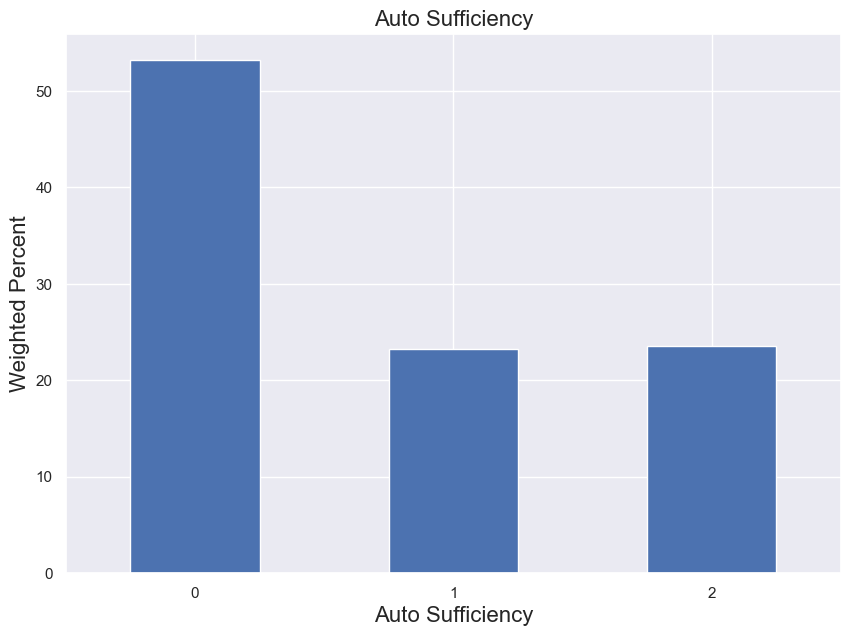

In [99]:
make_percentage_bar_plot(
    variable='auto_suff',
    title="Auto Sufficiency",
    xlabel="Auto Sufficiency",
    xlabel_rotation=0)



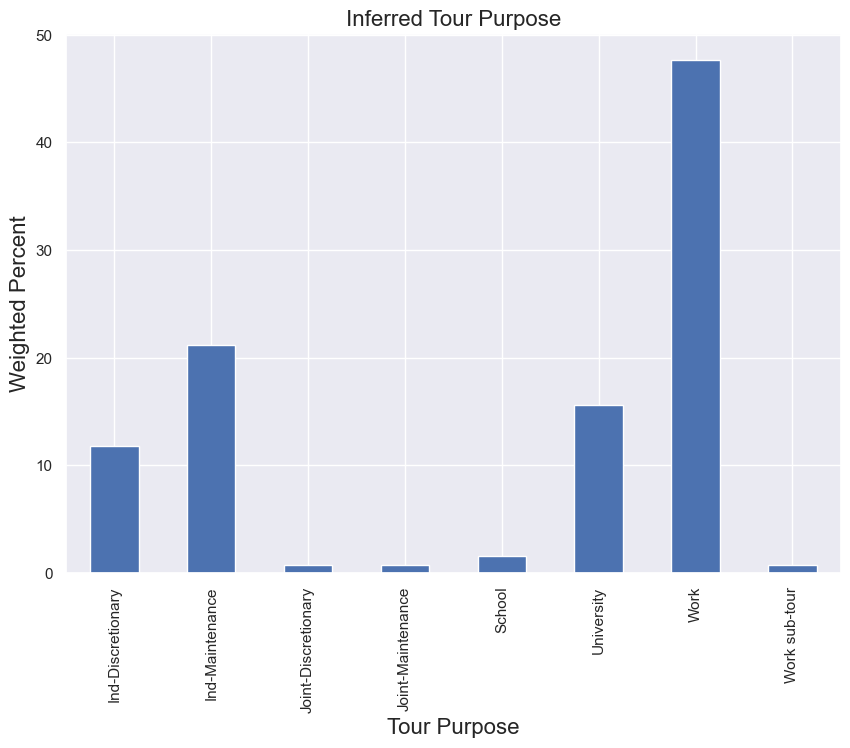

In [100]:
make_percentage_bar_plot(
    variable='TOUR_PURPOSE',
    title="Inferred Tour Purpose",
    xlabel="Tour Purpose",
    xlabel_rotation=90)


In [101]:
obs_df['TOUR_MODE'] = obs_df.apply(lambda row: determine_tour_mode(row), axis=1)
access_df = obs_df.groupby(['TOUR_MODE'])['linked_weight_scaled'].agg(sum).sort_index(level='TOUR_MODE').to_frame()
access_df['Percent'] = access_df['linked_weight_scaled'] / access_df['linked_weight_scaled'].sum() * 100



print(access_df)

obs_df.groupby(['TOUR_MODE'])['linked_weight_scaled'].agg(sum).sort_index(level='TOUR_MODE')

           linked_weight_scaled  Percent
TOUR_MODE                               
PNR                   10103.289    8.147
Walk                 113905.044   91.853


TOUR_MODE
PNR     10103.289
Walk   113905.044
Name: linked_weight_scaled, dtype: float64

## Summary tables

### Boardings by line

In [102]:

obs_df.ROUTE.value_counts()
obs_df.groupby(['ROUTE'])['unlinked_weight_scaled'].agg(sum) #.sort_index(level='ROUTE')

ROUTE
002          3563.502
003          4751.336
004          3069.665
005          6818.195
006          3680.643
               ...   
903           371.340
904          1358.373
921          3247.049
923          5760.991
OrangeLINK     38.446
Name: unlinked_weight_scaled, Length: 136, dtype: float64

In [103]:
mode_df = obs_df.groupby(['TOUR_MODE'])['linked_weight_scaled'].agg(sum).sort_index(level='TOUR_MODE').to_frame()
mode_df['Percent'] = mode_df['linked_weight_scaled'] / mode_df['linked_weight_scaled'].sum() * 100
display(HTML(mode_df.to_html()))

,linked_weight_scaled,Percent
TOUR_MODE,,
PNR,10103.289,8.147
Walk,113905.044,91.853


### Linked trips by transit mode + tour purpose

In [104]:
mode_purpose_ct = pd.crosstab(obs_df['TOUR_PURPOSE'], obs_df['TOUR_MODE'], values=obs_df['linked_weight_scaled'], aggfunc=sum, margins=True)
mode_purpose_ct = add_percentage_to_crosstab(mode_purpose_ct)
mode_purpose_ct.fillna(0, inplace=True)
mode_purpose_ct.applymap(lambda x: round(x,2))


TOUR_MODE,PNR,Walk,All,Percent
TOUR_PURPOSE,,,,
Ind-Discretionary,347.730,13880.800,14228.530,11.470
Ind-Maintenance,492.910,25727.200,26220.110,21.140
Joint-Discretionary,33.200,800.810,834.000,0.670
Joint-Maintenance,11.080,843.710,854.790,0.690
School,125.360,1913.900,2039.260,1.640
University,2059.660,19603.880,21663.530,17.470
Work,6960.660,50252.410,57213.070,46.140
Work sub-tour,72.680,882.350,955.030,0.770
All,10103.290,113905.040,124008.330,100.000


### Linked trips by tour purpose, auto sufficiency, and access mode

In [105]:
purpose_suff_access_ct = pd.crosstab(obs_df['TOUR_PURPOSE'], [obs_df['auto_suff'], obs_df['access_mode']], values=obs_df['linked_weight_scaled'], aggfunc=sum, margins=True)
purpose_suff_access_ct = add_percentage_to_crosstab(purpose_suff_access_ct)
purpose_suff_access_ct.fillna(0, inplace=True)
purpose_suff_access_ct.applymap(lambda x: round(x,2))

auto_suff                 0                  1                  2            \
access_mode             PNR      Walk      PNR      Walk      PNR      Walk   
TOUR_PURPOSE                                                                  
Ind-Discretionary    83.270  9668.250   25.870  2134.840   34.590  2281.720   
Ind-Maintenance     106.800 18664.360   36.010  3160.860  116.900  4135.180   
Joint-Discretionary   1.570   432.490    2.420   160.320    9.040   228.160   
Joint-Maintenance     3.870   401.290    4.240   197.270    2.970   245.150   
School                0.000   366.830   60.180   663.180   16.100   932.980   
University            5.730  9062.410  271.810  5112.640  782.090  6428.850   
Work                432.200 24960.610  788.720 16021.680 2520.500 12489.360   
Work sub-tour         8.100   454.680    1.400   231.330   44.190   215.330   
All                 641.540 64010.910 1190.660 27682.120 3526.380 26956.720   
Percent               0.520    51.620    0.960    22.320    2.840    21.740   

auto_suff                  All Percent  
access_mode                             
TOUR_PURPOSE                            
Ind-Discretionary    14228.530  11.470  
Ind-Maintenance      26220.110  21.140  
Joint-Discretionary    834.000   0.670  
Joint-Maintenance      854.790   0.690  
School                2039.260   1.640  
University           21663.530  17.470  
Work                 57213.070  46.140  
Work sub-tour          955.030   0.770  
All                 124008.330 100.000  
Percent                100.000   0.000

# Add Friendly Names for Reporting

In [106]:
obs_df['ROUTE'].unique()

array(['121', '122', '123', '003', '120', '902', '901', '923', '921',
       '010', '124', '006', '005', '002', '018', '021', '054', '027',
       '760', '763', '064', '032', '063', '515', '781', '777', '724',
       '774', '022', '850', '721', '074', '353', '017', '009', '667',
       '046', '004', '014', '067', '761', '612', '747', '094', '007',
       '904', '323', '011', '436', '446', '444', '445', '442', '465',
       '480', '440', '061', '489', '495', 'OrangeLINK', '420', '497',
       '499', '447', '470', '477', '460', '062', '493', '080', '484',
       '475', '490', '472', '071', '540', '755', '025', '070', '722',
       '537', '068', '903', '065', '083', '705', '801', '250', '033',
       '023', '615', '264', '363', '789', '075', '294', '538', '087',
       '723', '219', '645', '539', '768', '600', '270', '717', '698',
       '252', '542', '716', '785', '030', '114', '852', '673', '766',
       '831', '805', '534', '546', '113', '547', '227', '225', '804',
       '824', '115',

In [107]:
route_labels = {
    '888': 'Northstar',
    '901': 'Blue',
    '902': 'Green',
    '903': 'Red',
    '904': 'Orange',
    '921': 'A Line',
    '923': 'C Line'
}

def rl(x):
    x = str(x)
    if len(x) < 3:
        while len(x) < 3:
            x = '0' + x
    return(x)


obs_df['ROUTE_LABEL'] = obs_df['ROUTE'].apply(lambda x: route_labels[x] if x in route_labels.keys() else rl(x))

obs_df['ROUTE_LABEL'].value_counts()


Green     3022
Blue      2698
005        946
021        805
C Line     676
          ... 
795          4
115          3
776          2
252          2
690          1
Name: ROUTE_LABEL, Length: 136, dtype: int64

## Write coded output

In [108]:
obs_df.to_csv(os.path.join(output_path, 'processed_obs.csv'))

# Write Validation Data

This is to write a few files - a simpler file (by mode) and a detailed file (by route)

In [109]:
"""
    '888': 'Northstar',
    '901': 'Blue',
    '902': 'Green',
    '903': 'Red',
    '904': 'Orange',
    '921': 'A Line',
    '923': 'C Line'
    """


obs_df['MODE'] = 'bus'
# 888 is the Northstar line
obs_df.loc[obs_df['ROUTE'] == '888', 'MODE'] = 'CR'
#901/902 are LRT
obs_df.loc[obs_df['ROUTE'].isin(['901', '902']), 'MODE'] = 'LRT'
# A, C, D, Orange, and Red are BRT
#TODO: add D (not in 2018 transit)
obs_df.loc[obs_df['ROUTE'].isin(['921', '923', '903', '904']), 'MODE'] = 'BRT'



obs_df.groupby(['ROUTE_PROVIDER', 'ROUTE_LABEL']).agg(boardings = ('unlinked_weight_scaled', 'sum')).reset_index().to_excel(os.path.join(VALIDATION_DATA_FOLDER, 'transit_line_validation.xlsx'), index = False)

obs_df.groupby(['MODE']).agg(boardings = ('unlinked_weight_scaled', 'sum')).reset_index().to_excel(os.path.join(VALIDATION_DATA_FOLDER, 'transit_line_validation.xlsx'), index = False)
